<a href="https://colab.research.google.com/github/FalkaKrwawa/thyroid_disease/blob/main/Thyroid_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from ydata_profiling import ProfileReport

#Custom functions

In [2]:
def label_encoding(column):
  label_encoder = LabelEncoder()
  column_encoded = label_encoder.fit_transform(column)
  return column_encoded

In [3]:
def report(classificator, X_train, y_train, X_test, y_test):
  classificator.fit(X_train, y_train)
  y_pred = classificator.predict(X_test)
  print(classification_report(y_test, y_pred))
  print('\n')
  cm = confusion_matrix(y_test, y_pred, labels=classificator.classes_)
  display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classificator.classes_)
  display_cm.plot(xticks_rotation='vertical')
  plt.show()

In [4]:
def check_best_params(estimator, params, cv, X_train, y_train):
  estimator_grid = GridSearchCV(estimator, param_grid=params, n_jobs=-1, cv=cv)
  estimator_best_params = estimator_grid.fit(X_train, y_train)
  return estimator_best_params.best_params_

#EDA and data preparation

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Projects/Data/dataset_57_hypothyroid.csv'

In [6]:
df = pd.read_csv(path, na_values='?')

In [7]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [8]:
df.tail()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
3767,30.0,F,f,f,f,f,f,f,f,f,...,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,...,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,...,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,...,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative
3771,64.0,F,f,f,f,f,f,f,f,f,...,t,99.0,t,1.07,t,92.0,f,NaN,other,negative


In [9]:
df.drop(columns=['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured','TBG','hypopituitary'], axis=1, inplace=True)

In [10]:
df.dropna(axis=0, thresh=19, inplace=True)

In [11]:
df.drop(df[df.age>100].index, inplace=True)

In [12]:
df.drop(df[df.Class=='secondary_hypothyroid'].index, inplace=True)

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##Labeling and imputing missing values

In [15]:
X = df.drop(columns=['Class'], axis=1)
y = df['Class']

In [16]:
numerical_features = [i for i in X.columns if X.dtypes[i]=='float64']

In [17]:
knn_imputer = KNNImputer()
X[numerical_features] = knn_imputer.fit_transform(df[numerical_features])

In [18]:
categorical_features = [i for i in X.columns if X.dtypes[i]=='O']

In [19]:
features_to_label = categorical_features.copy()
features_to_label.remove('sex')
features_to_label.remove('referral_source')

In [20]:
X[features_to_label] = X[features_to_label].apply(lambda x: label_encoding(x))

In [21]:
categorical_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
X['sex'] = categorical_imputer.fit_transform(X['sex'].values.reshape(-1,1))

In [22]:
ohe = OneHotEncoder()

In [23]:
one_hot_encoded = ohe.fit_transform(X[['sex','referral_source']])

In [24]:
X_ohe_encoded = pd.DataFrame(one_hot_encoded.todense(), columns=ohe.get_feature_names_out()).reset_index(drop=True)

In [25]:
X = pd.concat((X, X_ohe_encoded), axis=1).reset_index(drop=True)
X.drop(columns=['sex','referral_source'], axis=1, inplace=True)

##Train/test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [27]:
num_features_to_scale = numerical_features.copy()
num_features_to_scale.remove('TSH')

In [28]:
min_max_scaler = MinMaxScaler()

In [29]:
X_train[num_features_to_scale] = min_max_scaler.fit_transform(X_train[num_features_to_scale])
X_test[num_features_to_scale] = min_max_scaler.transform(X_test[num_features_to_scale])

In [30]:
X_train['TSH'] = np.log(X_train['TSH'])
X_test['TSH'] = np.log(X_test['TSH'])

#Logistic regression

                         precision    recall  f1-score   support

compensated_hypothyroid       0.67      0.95      0.79        39
               negative       1.00      0.97      0.98       652
    primary_hypothyroid       0.70      0.89      0.78        18

               accuracy                           0.96       709
              macro avg       0.79      0.93      0.85       709
           weighted avg       0.97      0.96      0.97       709





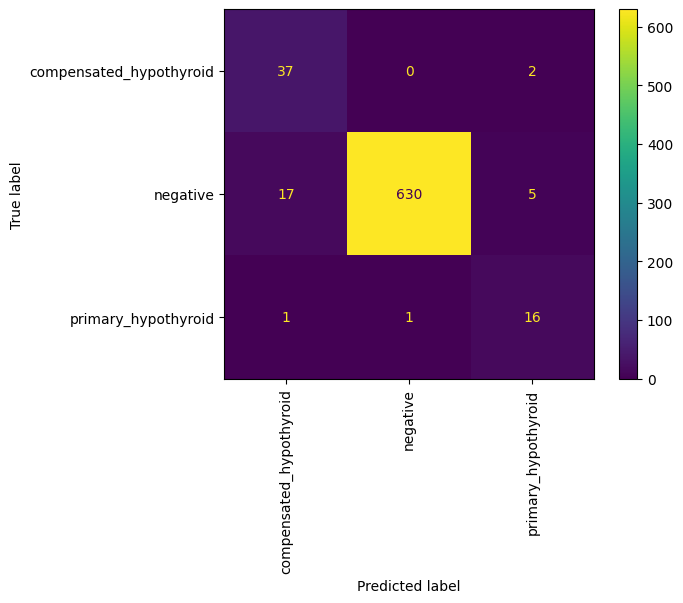

In [31]:
report(LogisticRegression(max_iter=256, class_weight='balanced', multi_class='multinomial', random_state=42), X_train, y_train, X_test, y_test)

In [32]:
logistic_regression_params = {
                              'solver':       ['newton-cg','lbfgs','liblinear'],
                              'penalty':      ['l2'],
                              'C':            [100, 10, 1.0, 0.1, 0.01],
                              'class_weight': ['balanced', None],
                              }

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [33]:
check_best_params(LogisticRegression(max_iter=256), logistic_regression_params, cv, X_train, y_train)

{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

                         precision    recall  f1-score   support

compensated_hypothyroid       0.80      0.92      0.86        39
               negative       0.99      0.98      0.99       652
    primary_hypothyroid       0.83      0.83      0.83        18

               accuracy                           0.98       709
              macro avg       0.88      0.91      0.89       709
           weighted avg       0.98      0.98      0.98       709





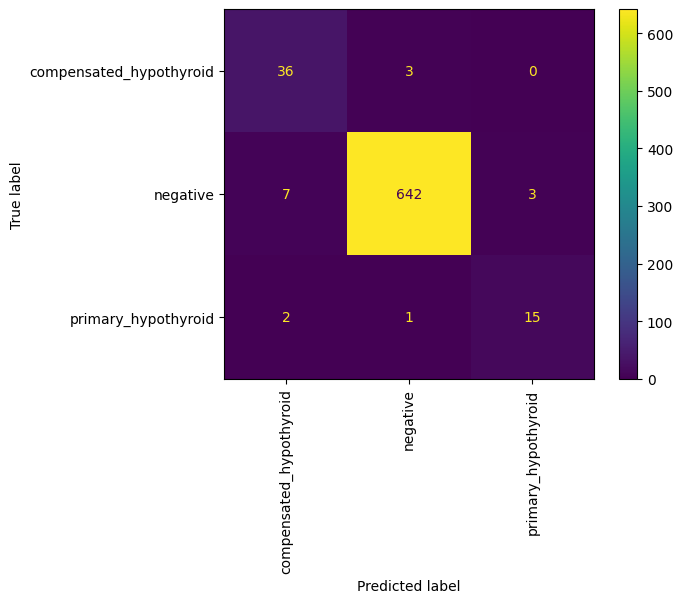

In [34]:
report(LogisticRegression(max_iter=256, C=100, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42), X_train, y_train, X_test, y_test)

#K-nearest neighbours

                         precision    recall  f1-score   support

compensated_hypothyroid       0.74      0.72      0.73        39
               negative       0.99      0.99      0.99       652
    primary_hypothyroid       0.70      0.78      0.74        18

               accuracy                           0.97       709
              macro avg       0.81      0.83      0.82       709
           weighted avg       0.97      0.97      0.97       709





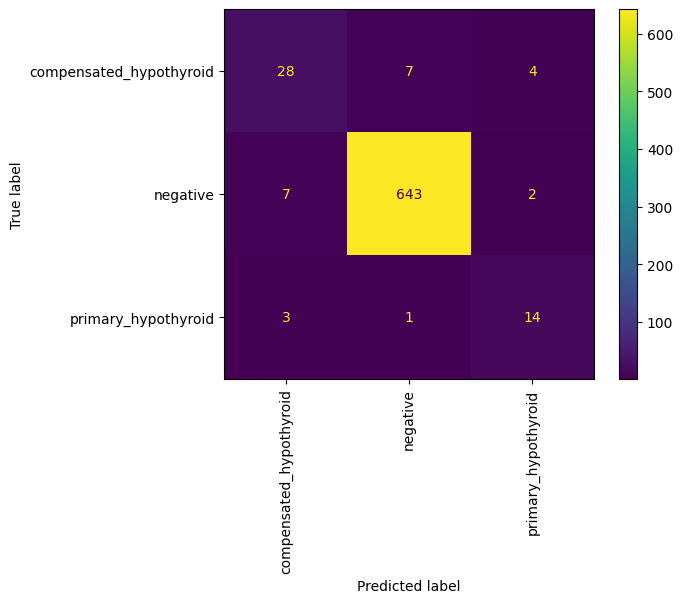

In [35]:
report(KNeighborsClassifier(weights='distance', n_jobs=-1), X_train, y_train, X_test, y_test)

In [36]:
knn_params = {
              'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
              'weights':     ['uniform','distance'],
              'metric':      ['minkowski','euclidean','manhattan']
              }

In [37]:
check_best_params(KNeighborsClassifier(), knn_params, cv, X_train, y_train)

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

                         precision    recall  f1-score   support

compensated_hypothyroid       0.81      0.74      0.77        39
               negative       0.99      0.99      0.99       652
    primary_hypothyroid       0.78      0.78      0.78        18

               accuracy                           0.97       709
              macro avg       0.86      0.84      0.85       709
           weighted avg       0.97      0.97      0.97       709





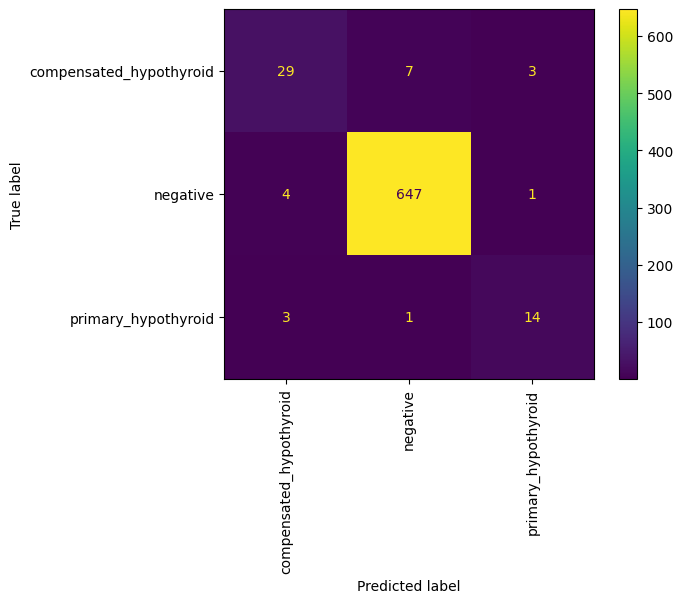

In [40]:
report(KNeighborsClassifier(weights='distance', n_neighbors=5, metric='manhattan'), X_train, y_train, X_test, y_test)